# Bayesian Sparse Logistic Regression with Sparse Prior via Bregman--Moreau Unadjusted Mirror Langevin Algorithms

In this notebook, we perform numerical simulations for Bayesian logistic regression: we observe samples of pairs $\{(\boldsymbol{x}_n, y_n) \}_{n=1}^N$, where $\boldsymbol{x}_n\in\mathbb{R}^d$ and $y_n\in\{0,1\}$. The data are assumed to follow the model 
$$ 
y_n \stackrel{\text{i.i.d.}}{\sim} \mathrm{Bernoulli}\!\left( \frac{\exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)}{1+\exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)}\right)
$$
for $n\in\{1, \ldots, N\}$. The parameter $\boldsymbol{\theta} = (\theta_i)_{1 \leqslant i \leqslant d}^\top\in\mathbb{R}^d$ is a random variable with a prior density $\lambda$ with respect to Lebesgue measure. Then, the posterior distribution $\pi$ takes the form 
$$p(\boldsymbol{\theta}\,|\,\{(\boldsymbol{x}_n, y_n) \}_{n=1}^N) \propto p(\boldsymbol{\theta}) \exp\left\lbrace\sum_{n=1}^N \left(y_n \langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle - \log (1 + \exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)) \right)\right\rbrace. $$

In this part, we are particularly concerned with the case with an anisotropic Laplace prior (sparsity-inducing) and a prior in the form of a combination of an anisotropic Laplace distribution and an anisotropic Gaussian distribution, where the unadjusted Langevin algorithm is no longer viable. In general, such priors take the form: 
$$ p(\boldsymbol{\theta})  \coloneqq p(\boldsymbol{\theta}\,|\,\boldsymbol{\alpha}_1, \boldsymbol{\alpha}_2) \propto \exp\left(- \sum_{i=1}^d \alpha_{1,i}|\theta_i| - \sum_{i=1}^d \alpha_{2,i}\theta_i^2 \right) , $$
where $\boldsymbol{\alpha}_1 = (\alpha_{1,i})_{1\le i\le d}^\top\in\mathbb{R}_+^d$ and  $\boldsymbol{\alpha}_2 = (\alpha_{1,i})_{2\le i\le d}^\top\in\mathbb{R}_+^d$. 

Then, the posterior distribution will have a potential in the following form:
$$
\sum_{n=1}^N \left[\log (1 + \exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)) - y_n \langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle \right] + \sum_{i=1}^d \alpha_{1,i}|\theta_i| + \sum_{i=1}^d \alpha_{2,i}\theta_i^2
$$

## Import libraries

In [1]:
import matplotlib.pyplot as plt
plt.style.use('science')

import numpy as np
import pandas as pd
import scipy
import scipy.special

from numpy.random import default_rng
rng = default_rng()

## Simulation of Data Points $\{(\boldsymbol{x}_n, y_n) \}_{n=1}^N$

In [2]:
d = 100
N = 1000

theta_star =  np.arange(10) / 10
theta_star = np.repeat(theta_star, 10)

np.random.seed(0)
X = np.random.randn(d, N)
logit = np.exp(np.dot(theta_star, X))/(1 + np.exp(np.dot(theta_star, X)))
Y = np.random.binomial(1, logit)

### Function to compute the gradient of the potential 
$$\nabla U(\boldsymbol{\theta}) = -\sum_{n=1}^N \left(y_n - \frac{\exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)}{1+\exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)} \right) \boldsymbol{x}_n$$

In [3]:
def grad_potential(theta: np.ndarray, 
                   X: np.ndarray, 
                   Y: np.ndarray) -> np.ndarray: 
    ''' 
    theta: d by 1 vector: parameter of the Bayesian logistic regression model
    X: d by N matrix: each column is X_n
    Y: N by 1 vector: each entry is Y_n
    '''
    return - np.einsum('i,ji->j', Y - scipy.special.expit(np.dot(theta, X)), X)

### Function to compute the Hessian of the potential
$$\nabla^2 U(\boldsymbol{\theta}) = \sum_{n=1}^N \frac{\exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)}{(1+\exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle))^2}\ \boldsymbol{x}_n \boldsymbol{x}_n^\top$$

In [4]:
def hess_potential(theta: np.ndarray, 
                   X: np.ndarray) -> np.ndarray:
    ''' 
    beta: d by 1 vector: parameter of the Bayesian logistic regression model
    X: d by N matrix: each column is X_n
    '''
    outer_prod = np.empty((N, d, d))

    for n in range(N):
        outer_prod[n,:,:] = np.outer(X[:,n], X[:,n])

    logistic_pdf = lambda x : np.where(x < 0, np.exp(x)/(1 + np.exp(x)) ** 2, np.exp(-x)/(1 + np.exp(-x)) ** 2)


    hess = np.einsum('i,ijk->jk', logistic_pdf(np.dot(theta, X)), outer_prod)

    return hess

## Hypentropy mirror map
$$
\varphi(\boldsymbol{\theta}) = \sum_{i=1}^d \left[ \theta_i \operatorname{arsinh}\left( \frac{\theta_i}{\beta_i} \right) - \sqrt{\theta_i^2 + \beta_i^2}\right]
$$

In [5]:
def mirror_hyp(theta, beta) -> float: 
    return theta.dot(np.arcsinh(theta / beta)) - np.sum(np.sqrt(theta**2 + beta**2))

$$
\nabla \varphi(\boldsymbol{\theta}) = \left( \operatorname{arsinh}(\theta_i/\beta_i) \right)_{1 \leqslant i \leqslant d}^\top
$$

In [6]:
def grad_mirror_hyp(theta, beta) -> np.ndarray: 
    return np.arcsinh(theta / beta)

$$
\nabla\varphi^*(\boldsymbol{\theta}) = \left( \beta_i\sinh(\theta_i) \right)_{i\leqslant i \leqslant d}
$$

In [7]:
def grad_conjugate_mirror_hyp(theta, beta) -> np.ndarray:
    return beta * np.sinh(theta)

### Bregman proximity operator of $\|\cdot\|_1$ with $\psi$ being the hypentropy
$$
\overleftarrow{\operatorname{P}}_{\negthinspace\negthinspace \lambda, g}^\psi(\boldsymbol{\theta}) = \operatorname{argmin}_{\boldsymbol{\vartheta}\in\mathbb{R}^d} \left\{\|\boldsymbol{\vartheta}\|_1 + \frac1\lambda D_\psi(\boldsymbol{\vartheta}, \boldsymbol{\theta})  \right\}
$$ 

In [8]:
def left_bregman_prox_ell_one_hypent(theta, beta, gamma) -> np.ndarray:
    if isinstance(theta, float):
        if theta > beta * np.sinh(gamma):
            prox = beta * np.sinh(np.arcsinh(theta / beta) - gamma)
        elif theta < beta * np.sinh(-gamma):
            prox = beta * np.sinh(np.arcsinh(theta / beta) + gamma)
        else: 
            prox = np.sqrt(theta ** 2 + beta ** 2) - beta
    else:
        prox = np.array(len(theta))
        p1 = beta * np.sinh(np.arcsinh(theta / beta) - gamma)
        p2 = beta * np.sinh(np.arcsinh(theta / beta) + gamma)
        p3 = np.sqrt(theta ** 2 + beta ** 2) - beta
        prox = np.where(theta > beta * np.sinh(gamma), p1, p3)
        prox = np.where(theta < beta * np.sinh(-gamma), p2, prox)
    return prox

### Proximity operator of $\| \cdot\|_1$ 
$$\operatorname{prox}_{\lambda\|\cdot\|_1}(\boldsymbol{\theta}) = \left(\operatorname{sign}(\theta_i) \max\{|\theta_i| -\lambda, 0\}\right)_{1\leqslant i \leqslant d}, \quad \lambda >0 $$ 

In [9]:
def prox_abs(theta, lam) -> np.ndarray:
    return np.sign(theta) * np.maximum(np.abs(theta) - lam, 0)

### Initializations

In [10]:
K = 4000

alpha1 = np.arange(11)[11:0:-1]
alpha1 = np.repeat(alpha1, 10)

alpha2 = 0.1

### The Moreau-Yosida Unadjusted Langevin Algorithm (MYULA) ([Brosse et al., 2017](http://proceedings.mlr.press/v65/brosse17a.html); [Durmus et al., 2018](https://epubs.siam.org/doi/abs/10.1137/16M1108340))
$$ \boldsymbol{\theta}_{k+1} = \boldsymbol{\theta}_k - \gamma_k \nabla U(\boldsymbol{\theta}_k) - \frac{\gamma_k}{\lambda} \left(\boldsymbol{\theta}_k - \operatorname{prox}_{\lambda g}(\boldsymbol{\theta}_k) \right) + \sqrt{2\gamma_k}\,\boldsymbol{\xi}_{k}, \quad \boldsymbol{\xi}_k \stackrel{\text{i.i.d.}}{\sim}\mathsf{N}(\boldsymbol{0}, \boldsymbol{I}_d)$$

In [11]:
def myula(gamma, lam, alpha1, alpha2, X, Y, theta_star, seed, d=100, K=100000, print_freq=1000):
    np.random.seed(seed)
    theta0 = np.random.normal(0, 1, d)
    theta = []
    error = []

    for i in range(K):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = theta0 - gamma * grad_potential(theta0, X, Y) - gamma * alpha2 * theta0  - gamma/lam * (theta0 - prox_abs(theta0, lam * alpha1)) + np.sqrt(2*gamma) * xi
        theta.append(theta_new) 
        error.append(np.linalg.norm(theta_new - theta_star))
        if i == 0 or i % print_freq == print_freq - 1:
            print('iteration {}: error = {}'.format(i + 1, np.linalg.norm(theta_new - theta_star)))           
        theta0 = theta_new

    return theta, error

### MYULA Main Loop

In [12]:
S = 30
Theta1 = []
Error1 = []

for j in range(S):
    print('j =', j)
    theta1, error1 = myula(5e-4, 1e-2, alpha1, alpha2, X, Y, theta_star, j, d, K)
    Theta1.append(theta1)
    Error1.append(error1)

j = 0
iteration 1: error = 11.123829347628348
iteration 1000: error = 2.052913875371309
iteration 2000: error = 1.8214911014880368
iteration 3000: error = 1.9550566296466951
iteration 4000: error = 2.2075158680222904
j = 1
iteration 1: error = 9.55978907030871
iteration 1000: error = 2.177555806074937
iteration 2000: error = 1.7533468094496574
iteration 3000: error = 2.053901125675032
iteration 4000: error = 2.2638835714899335
j = 2
iteration 1: error = 11.58406739795639
iteration 1000: error = 1.9694770055581305
iteration 2000: error = 2.053205061163132
iteration 3000: error = 1.9148450946430149
iteration 4000: error = 2.143484397797184
j = 3
iteration 1: error = 11.921598045070919
iteration 1000: error = 2.0172648775116664
iteration 2000: error = 2.1260166689489943
iteration 3000: error = 1.9362939604994442
iteration 4000: error = 1.845208587876154
j = 4
iteration 1: error = 10.733725466369195
iteration 1000: error = 2.3755244187758247
iteration 2000: error = 2.041730873413862
iterat

In [13]:
theta1 = np.mean(np.array(Theta1), axis=0)
error1 = np.array([np.linalg.norm(theta1[i] - theta_star) for i in range(K)])

### Plot of Errors

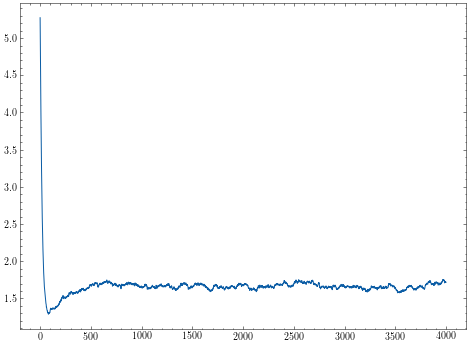

In [14]:
plt.figure(0, figsize=(8,6))
plt.plot(np.arange(K), error1)

## The Bregman--Moreau Unadjusted Mirror Langevin Algorithm (BMUMLA) 
$$ \boldsymbol{\theta}_{k+1} = \nabla \varphi^*\!\!\left(\nabla \varphi\left(\boldsymbol{\theta}_k \right) - \gamma_k \nabla U_\lambda^\psi(\boldsymbol{\theta}_k) + \sqrt{2\gamma_k}\left[\nabla^2\varphi(\boldsymbol{\theta}_k) \right]^{1/2} \boldsymbol{\xi}_{k}\right), \quad \boldsymbol{\xi}_k \stackrel{\text{i.i.d.}}{\sim} \mathsf{N}(\boldsymbol{0}, \boldsymbol{I}_d)$$

In [15]:
def lbmumla_hyp_hyp(gamma, lam, alpha1, alpha2, beta, sigma, X, Y, theta_star, seed, d=100, K=100000, print_freq=1000):
    np.random.seed(seed)
    theta0 = np.random.normal(0, 1, d)
    theta = []
    error = []

    for i in range(K):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = grad_mirror_hyp(theta0, beta) - gamma * (grad_potential(theta0, X, Y) + alpha2 * theta0 + 1/lam * (theta0**2 + sigma**2)**(-.5) * (theta0 - left_bregman_prox_ell_one_hypent(theta0, sigma, lam * alpha1))) + np.sqrt(2*gamma) * (theta0**2 + beta**2)**(-.25) * xi
        theta_new = grad_conjugate_mirror_hyp(theta_new, beta)
        theta.append(theta_new) 
        error.append(np.linalg.norm(theta_new - theta_star))
        if i == 0 or i % print_freq == print_freq - 1:
            print('iteration {}: error = {}'.format(i + 1, np.linalg.norm(theta_new - theta_star)))   
        theta0 = theta_new

    return theta, error

### Setting the values of $\boldsymbol{\beta}$ and $\boldsymbol{\sigma}$

In [16]:
beta = np.arange(1, 11)
beta = np.repeat(beta, 10)
beta = 2 * beta**.25
sigma = alpha1**2

### LBMUMLA Main Loop

In [17]:
Theta2 = []
Error2 = []

for j in range(S):
    print('j =', j)
    theta2, error2 = lbmumla_hyp_hyp(5e-4, 1e-2, alpha1, alpha2, beta, sigma, X, Y, theta_star, j, d, K)
    Theta2.append(theta2)
    Error2.append(error2)

j = 0
iteration 1: error = 10.63135215358398
iteration 1000: error = 1.7722912549659897
iteration 2000: error = 1.6536394947696567
iteration 3000: error = 1.8265869458699102
iteration 4000: error = 1.8839068394063545
j = 1
iteration 1: error = 8.98374685475345
iteration 1000: error = 1.8420644539044848
iteration 2000: error = 1.546090480274163
iteration 3000: error = 1.559401218681991
iteration 4000: error = 1.7635367452298911
j = 2
iteration 1: error = 10.93840455928139
iteration 1000: error = 1.8288937220963248
iteration 2000: error = 1.7425691722906667
iteration 3000: error = 1.796691064912534
iteration 4000: error = 1.4269455181820303
j = 3
iteration 1: error = 11.260520718907783
iteration 1000: error = 1.9224402601876625
iteration 2000: error = 1.9210893624532315
iteration 3000: error = 1.7342511662379725
iteration 4000: error = 1.7334658251219328
j = 4
iteration 1: error = 10.145084584183769
iteration 1000: error = 1.6302425460038246
iteration 2000: error = 1.6686402233141917
ite

In [18]:
theta2 = np.mean(np.array(Theta2), axis=0)
error2 = np.array([np.linalg.norm(theta2[i] - theta_star) for i in range(K)])

### Plots of Errors

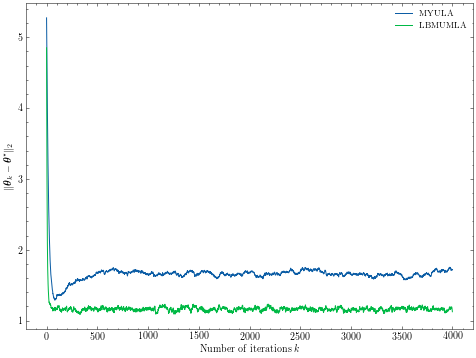

In [20]:
T = 4000
plt.figure(1, figsize=(8,6))
plt.plot(np.arange(T), error1[0:T], label="MYULA")
plt.plot(np.arange(T), error2[0:T], label="LBMUMLA")
plt.xlabel('Number of iterations $k$')
plt.ylabel('$\|\\boldsymbol{\\theta}_k - \\boldsymbol{\\theta}^\star\|_2$')
plt.legend(fontsize='small')
plt.savefig('../fig/logistic_error_1.pdf', dpi=500)

### Plot of Errors $|\theta_{i,k} - \theta_{i}^\star|$ of the $i$-th dimension at iteration $k$ for MYULA

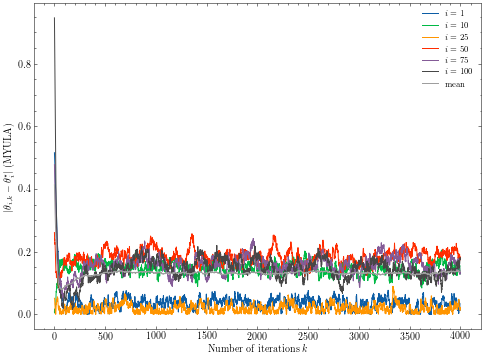

In [21]:
theta1_1 = [theta1[i][0] for i in range(K)]
error1_1 = np.abs(np.array(theta1_1) - theta_star[0])

theta1_10 = [theta1[i][9] for i in range(K)]
error1_10 = np.abs(np.array(theta1_10) - theta_star[9])

theta1_25 = [theta1[i][24] for i in range(K)]
error1_25 = np.abs(np.array(theta1_25) - theta_star[24])

theta1_50 = [theta1[i][49] for i in range(K)]
error1_50 = np.abs(np.array(theta1_50) - theta_star[49])

theta1_75 = [theta1[i][74] for i in range(K)]
error1_75 = np.abs(np.array(theta1_75) - theta_star[74])

theta1_100 = [theta1[i][99] for i in range(K)]
error1_100 = np.abs(np.array(theta1_100) - theta_star[99])


theta1_mean = [np.mean(theta1[i]) for i in range(K)]
error1_mean = np.abs(np.array(theta1_mean) - np.mean(theta_star))

plt.figure(2, figsize=(8,6))
plt.plot(np.arange(T), error1_1[0:T], label="$i=1$")
plt.plot(np.arange(T), error1_10[0:T], label="$i=10$")
plt.plot(np.arange(T), error1_25[0:T], label="$i=25$")
plt.plot(np.arange(T), error1_50[0:T], label="$i=50$")
plt.plot(np.arange(T), error1_75[0:T], label="$i=75$")
plt.plot(np.arange(T), error1_100[0:T], label="$i=100$")
plt.plot(np.arange(T), error1_mean[0:T], label="mean")
plt.xlabel('Number of iterations $k$')
plt.ylabel('$|\\theta_{i,k} - \\theta_{i}^\star|$ (MYULA)')
plt.legend(fontsize='small')

### Plot of Errors $|\theta_{i,k} - \theta_{i}^\star|$ of the $i$-th dimension at iteration $k$ for LBMUMLA

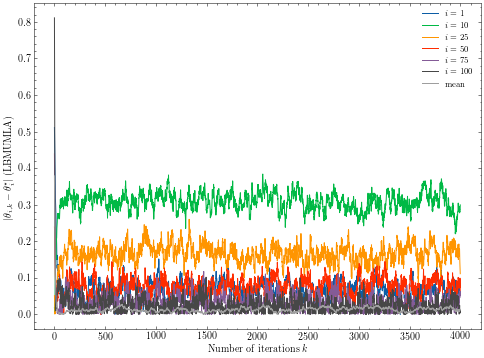

In [22]:
theta2_1 = [theta2[i][0] for i in range(K)]
error2_1 = np.abs(np.array(theta2_1) - theta_star[0])

theta2_10 = [theta2[i][9] for i in range(K)]
error2_10 = np.abs(np.array(theta2_10) - theta_star[9])

theta2_25 = [theta2[i][24] for i in range(K)]
error2_25 = np.abs(np.array(theta2_25) - theta_star[24])

theta2_50 = [theta2[i][49] for i in range(K)]
error2_50 = np.abs(np.array(theta2_50) - theta_star[49])

theta2_75 = [theta2[i][74] for i in range(K)]
error2_75 = np.abs(np.array(theta2_75) - theta_star[74])

theta2_100 = [theta2[i][99] for i in range(K)]
error2_100 = np.abs(np.array(theta2_100) - theta_star[99])

theta2_mean = [np.mean(theta2[i]) for i in range(K)]
error2_mean = np.abs(np.array(theta2_mean) - np.mean(theta_star))

plt.figure(3, figsize=(8,6))
plt.plot(np.arange(T), error2_1[0:T], label="$i=1$")
plt.plot(np.arange(T), error2_10[0:T], label="$i=10$")
plt.plot(np.arange(T), error2_25[0:T], label="$i=25$")
plt.plot(np.arange(T), error2_50[0:T], label="$i=50$")
plt.plot(np.arange(T), error2_75[0:T], label="$i=75$")
plt.plot(np.arange(T), error2_100[0:T], label="$i=100$")
plt.plot(np.arange(T), error2_mean[0:T], label="mean")
plt.xlabel('Number of iterations $k$')
plt.ylabel('$|\\theta_{i,k} - \\theta_{i}^\star|$ (LBMUMLA)')
plt.legend(fontsize='small')

### Plot of Errors $|\theta_{1,k} - \theta_{1}^\star|$ of the 1st dimension at iteration $k$ for MYULA and LBMUMLA

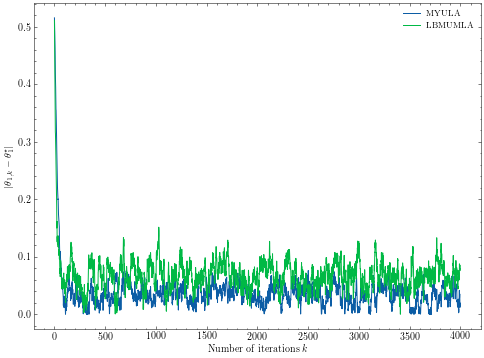

In [23]:
plt.figure(4, figsize=(8,6))
plt.plot(np.arange(T), error1_1[0:T], label='MYULA')
plt.plot(np.arange(T), error2_1[0:T], label='LBMUMLA')

plt.xlabel('Number of iterations $k$')
plt.ylabel('$|\\theta_{1,k} - \\theta_1^\star|$')
plt.legend(fontsize='small')
plt.savefig('../fig/logistic_error_single_1.pdf', dpi=500)

### Plot of Errors $|\theta_{10,k} - \theta_{10}^\star|$ of the 10th dimension at iteration $k$ for MYULA and LBMUMLA

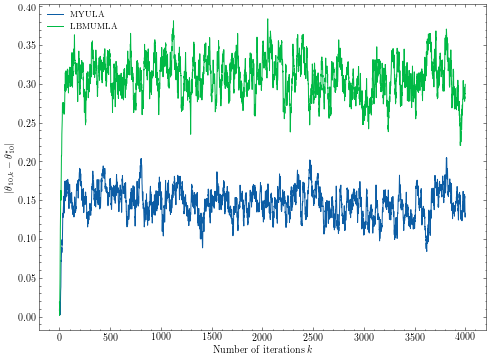

In [24]:
plt.figure(10, figsize=(8,6))
plt.plot(np.arange(T), error1_10[0:T], label='MYULA')
plt.plot(np.arange(T), error2_10[0:T], label='LBMUMLA')

plt.xlabel('Number of iterations $k$')
plt.ylabel('$|\\theta_{10,k} - \\theta_{10}^\star|$')
plt.legend(fontsize='small')
plt.savefig('../fig/logistic_error_single_10.pdf', dpi=500)

### Plot of Errors $|\theta_{25,k} - \theta_{25}^\star|$ of the 25th dimension at iteration $k$ for MYULA and LBMUMLA

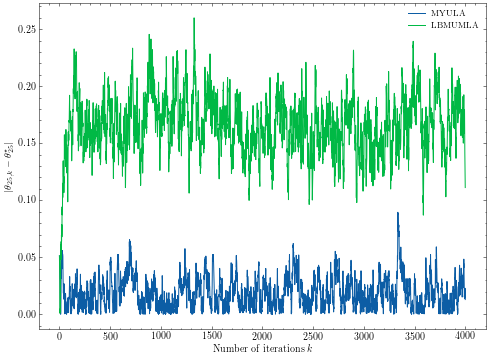

In [25]:
plt.figure(5, figsize=(8,6))
plt.plot(np.arange(T), error1_25[0:T], label='MYULA')
plt.plot(np.arange(T), error2_25[0:T], label='LBMUMLA')

plt.xlabel('Number of iterations $k$')
plt.ylabel('$|\\theta_{25,k} - \\theta_{25}^\star|$')
plt.legend(fontsize='small')
plt.savefig('../fig/logistic_error_single_25.pdf', dpi=500)

### Plot of Errors $|\theta_{50,k} - \theta_{50}^\star|$ of the 50th dimension at iteration $k$ for MYULA and LBMUMLA

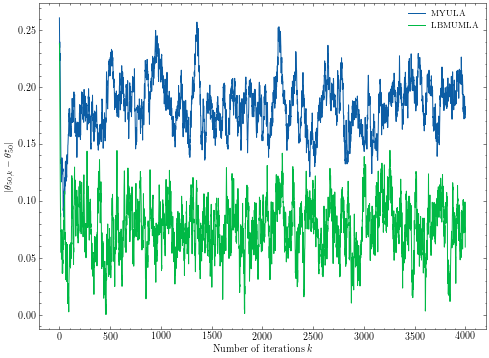

In [26]:
plt.figure(6, figsize=(8,6))
plt.plot(np.arange(T), error1_50[0:T], label='MYULA')
plt.plot(np.arange(T), error2_50[0:T], label='LBMUMLA')

plt.xlabel('Number of iterations $k$')
plt.ylabel('$|\\theta_{50,k} - \\theta_{50}^\star|$')
plt.legend(fontsize='small')
plt.savefig('../fig/logistic_error_single_50.pdf', dpi=500)

### Plot of Errors $|\theta_{75,k} - \theta_{75}^\star|$ of the 75th dimension at iteration $k$ for MYULA and LBMUMLA

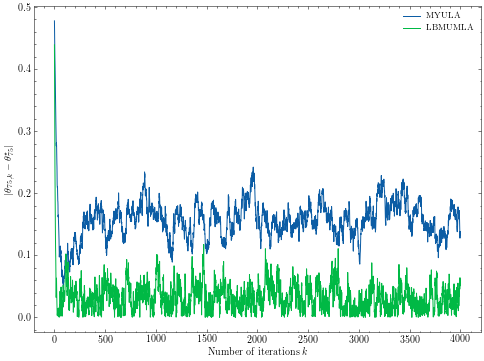

In [27]:
plt.figure(7, figsize=(8,6))
plt.plot(np.arange(T), error1_75[0:T], label='MYULA')
plt.plot(np.arange(T), error2_75[0:T], label='LBMUMLA')

plt.xlabel('Number of iterations $k$')
plt.ylabel('$|\\theta_{75,k} - \\theta_{75}^\star|$')
plt.legend(fontsize='small')
plt.savefig('../fig/logistic_error_single_75.pdf', dpi=500)

### Plot of Errors $|\theta_{100,k} - \theta_{100}^\star|$ of the 100th dimension at iteration $k$ for MYULA and LBMUMLA

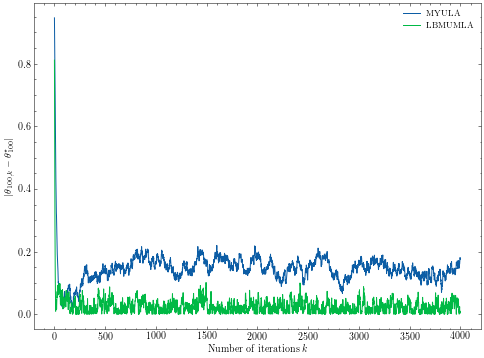

In [28]:
plt.figure(8, figsize=(8,6))
plt.plot(np.arange(T), error1_100[0:T], label='MYULA')
plt.plot(np.arange(T), error2_100[0:T], label='LBMUMLA')

plt.xlabel('Number of iterations $k$')
plt.ylabel('$|\\theta_{100,k} - \\theta_{100}^\star|$')
plt.legend(fontsize='small')
plt.savefig('../fig/logistic_error_single_100.pdf', dpi=500)

### Plot of Errors $|\|\boldsymbol{\theta}_{k}\|_2^2 - \|\boldsymbol{\theta}^\star\|_2^2|/d$ at iteration $k$ for MYULA and LBMUMLA

In [29]:
theta1_mean_sq = np.mean(np.linalg.norm(np.array(Theta1), axis=2)**2 / d, axis=0)
error1_mean_sq = np.array([abs(theta1_mean_sq[i] - np.linalg.norm(theta_star)**2 / d) for i in range(K)])

theta2_mean_sq = np.mean(np.linalg.norm(np.array(Theta2), axis=2)**2 / d, axis=0)
error2_mean_sq = np.array([abs(theta2_mean_sq[i] - np.linalg.norm(theta_star)**2 / d) for i in range(K)])

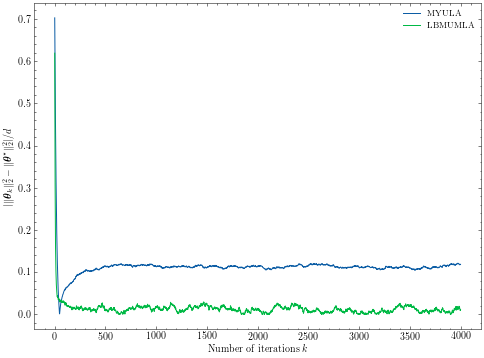

In [30]:
plt.figure(9, figsize=(8,6))
plt.plot(np.arange(T), error1_mean_sq[0:T], label='MYULA')
plt.plot(np.arange(T), error2_mean_sq[0:T], label='LBMUMLA')

plt.xlabel('Number of iterations $k$')
plt.ylabel('$|\|\\boldsymbol{\\theta}_{k}\|_2^2 - \|\\boldsymbol{\\theta}^\star\|_2^2|/d$')
plt.legend(fontsize='small')
plt.savefig('../fig/logistic_error_2.pdf', dpi=500)